# Packages

In [1]:
import pandas as pd
from copy import deepcopy
from sklearn import metrics
from iteration_utilities import deepflatten
from lightgbm import LGBMRegressor
from tqdm import tqdm_notebook as tqdm
import math
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from statsmodels.formula.api import ols
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
import itertools
import pylab 
from sklearn.model_selection import RepeatedKFold
from hyperopt import hp
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor
from numpy import percentile
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import joblib
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from numpy import mean
from numpy import std
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import ensemble
from sklearn.model_selection import validation_curve
from statistics import mean
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import norm
from scipy import stats
from sklearn.ensemble import AdaBoostRegressor
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesRegressor
import warnings
warnings.filterwarnings('ignore')

# Price Prediction

## Train/Test Split

In [2]:
apartments = pd.read_excel('apartments_no_outliers_concatenated.xlsx')
houses = pd.read_excel('houses_no_outliers_concatenated.xlsx')


apartments_ratings = pd.read_excel('apartments_immonet_no_outliers.xlsx')
apartments_ratings.drop('Link', axis=1, inplace=True)
houses_ratings = pd.read_excel('houses_immonet_no_outliers.xlsx')
houses_ratings.drop('Link', axis=1, inplace=True)
houses_ratings.drop('House Type', axis=1, inplace=True)

apartments_ratings[apartments_ratings.columns[apartments_ratings.isna().any()]] = apartments_ratings[apartments_ratings.columns[apartments_ratings.isna().any()]].fillna(apartments_ratings.median())

houses_ratings[houses_ratings.columns[houses_ratings.isna().any()]] = houses_ratings[houses_ratings.columns[houses_ratings.isna().any()]].fillna(houses_ratings.median())

In [3]:
X_apartments = apartments.drop(columns=['Price'])
y_apartments = apartments['Price']

X_houses = houses.drop(columns=['Price'])
y_houses = houses['Price']

X_apartments_rating = apartments_ratings.drop(columns=['Price'])
y_apartments_rating = apartments_ratings['Price']

X_houses_rating = houses_ratings.drop(columns=['Price'])
y_houses_rating = houses_ratings['Price']

In [4]:
X_houses_train, X_houses_test, y_houses_train, y_houses_test = train_test_split(X_houses, y_houses,
                                                                                test_size=0.1,
                                                                                random_state=50)

In [5]:
X_apartments_train, X_apartments_test, y_apartments_train, y_apartments_test = train_test_split(X_apartments, y_apartments,
                                                                                test_size=0.2,
                                                                                random_state=50)

In [6]:
X_houses_rating_train, X_houses_rating_test, y_houses_rating_train, y_houses_rating_test = train_test_split(X_houses_rating, y_houses_rating,
                                                                                test_size=0.1,
                                                                                random_state=50)

In [7]:
X_apartments_rating_train, X_apartments_rating_test, y_apartments_rating_train, y_apartments_rating_test = train_test_split(X_apartments_rating, y_apartments_rating,
                                                                                test_size=0.2,
                                                                                random_state=50)

In [28]:
X_apartments_train_nospatial = X_apartments_train.drop(columns=['Zip Code', 'Latitude', 'Longitude'])
X_apartments_test_nospatial = X_apartments_test.drop(columns=['Zip Code', 'Latitude', 'Longitude'])

X_houses_train_nospatial = X_houses_train.drop(columns=['Zip Code', 'Latitude', 'Longitude'])
X_houses_test_nospatial = X_houses_test.drop(columns=['Zip Code', 'Latitude', 'Longitude'])

## XGB

In [10]:
def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.1],
        'min_child_weight': [1, 3, 5],
        'n_estimators': [1000, 1500, 2000, 2500, 3000],
    }

    xgb_model = XGBRegressor(tree_method='gpu_hist', gpu_id=0) 

    random_search = RandomizedSearchCV(estimator=xgb_model,
                                       param_distributions=param_tuning,
                                       scoring='neg_mean_squared_error',
                                       cv=5,
                                       n_jobs=-1,
                                       verbose=2,
                                       n_iter=10)

    random_search.fit(X_train, y_train)

    return random_search.best_params_

### Apartments

In [10]:
tune = hyperParameterTuning(X_apartments_train,
                            y_apartments_train)

xgb_model = XGBRegressor(
    tree_method='gpu_hist',
    gpu_id=0,
    learning_rate=tune['learning_rate'],
    min_child_weight=tune['min_child_weight'],
    n_estimators=tune['n_estimators']
)

# Train the model with early stopping
xgb_model.fit(X_apartments_train,
              y_apartments_train,
              early_stopping_rounds=5,
              eval_set=[(X_apartments_test, y_apartments_test)],
              verbose=False)


y_pred_xgb = xgb_model.predict(X_apartments_test)
mse_xgb = mean_absolute_error(y_apartments_test, y_pred_xgb)
mape_xgb = mean_absolute_percentage_error(y_apartments_test, y_pred_xgb)


print("MAE: ", mse_xgb)
print("MAPE: ", mape_xgb)
print("R2: ", r2_score(y_apartments_test, y_pred_xgb))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
MAE:  149.42951843835118
MAPE:  2.720523878228828
R2:  0.7541888573463253


### Houses

In [11]:
tune = hyperParameterTuning(X_houses_train,
                            y_houses_train)

xgb_model2 = XGBRegressor(
    tree_method='gpu_hist',
    gpu_id=0,
    learning_rate=tune['learning_rate'],
    min_child_weight=tune['min_child_weight'],
    n_estimators=tune['n_estimators']
)

# Train the model with early stopping
xgb_model2.fit(X_houses_train,
              y_houses_train,
              early_stopping_rounds=5,
              eval_set=[(X_houses_train, y_houses_train)],
              verbose=False)


y_pred_xgb2 = xgb_model2.predict(X_houses_test)
mse_xgb2 = mean_absolute_error(y_houses_test, y_pred_xgb2)
mape_xgb2 = mean_absolute_percentage_error(y_houses_test, y_pred_xgb2)


print("MAE: ", mse_xgb2)
print("MAPE: ", mape_xgb2)
print("R2: ", r2_score(y_houses_test, y_pred_xgb2))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
MAE:  322.5357528997927
MAPE:  8.483863812972897
R2:  0.5912770428913885


### Houses w/o Spatial Data

In [29]:
xgb_model5 = XGBRegressor(
    tree_method='gpu_hist',
    gpu_id=0,
)

# Train the model with early stopping
xgb_model5.fit(X_houses_train_nospatial,
              y_houses_train,
              early_stopping_rounds=5,
              eval_set=[(X_houses_train_nospatial, y_houses_train)],
              verbose=False)


y_pred_xgb5 = xgb_model5.predict(X_houses_test_nospatial)
mse_xgb5 = mean_absolute_error(y_houses_test, y_pred_xgb5)
mape_xgb5 = mean_absolute_percentage_error(y_houses_test, y_pred_xgb5)


print("MAE: ", mse_xgb5)
print("MAPE: ", mape_xgb5)
print("R2: ", r2_score(y_houses_test, y_pred_xgb5))

MAE:  450.7396187918527
MAPE:  11.174483553674825
R2:  0.23870772162494758


In [34]:
X_houses_nospatial = X_houses.drop(columns=['Zip Code', 'Latitude', 'Longitude'])
houses_nonspatial_predictions = xgb_model5.predict(X_houses_nospatial)

houses_nonspatial = X_houses
houses_nonspatial['Predictions'] = houses_nonspatial_predictions

houses_nonspatial.to_excel('housesNonSpatialPredictions.xlsx', index=False)

### Apartments with Rating Metrics

In [12]:
tune = hyperParameterTuning(X_apartments_rating_train,
                            y_apartments_rating_train)

xgb_model3 = XGBRegressor(
    tree_method='gpu_hist',
    gpu_id=0,
    learning_rate=tune['learning_rate'],
    min_child_weight=tune['min_child_weight'],
    n_estimators=tune['n_estimators']
)

# Train the model with early stopping
xgb_model3.fit(X_apartments_rating_train,
              y_apartments_rating_train,
              early_stopping_rounds=5,
              eval_set=[(X_apartments_rating_train, y_apartments_rating_train)],
              verbose=False)


y_pred_xgb3 = xgb_model3.predict(X_apartments_rating_test)

mse_xgb3 = mean_absolute_error(y_apartments_rating_test, y_pred_xgb3)
mape_xgb3 = mean_absolute_percentage_error(y_apartments_rating_test, y_pred_xgb3)


print("MAE: ", mse_xgb3)
print("MAPE: ", mape_xgb3)
print("R2: ", r2_score(y_apartments_rating_test, y_pred_xgb3))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
MAE:  125.05479445583431
MAPE:  0.16253242751191632
R2:  0.8559961498662265


### Apartments w/o Spatial Data

In [10]:
xgb_model4 = XGBRegressor(
    tree_method='gpu_hist',
    gpu_id=0
)

# Train the model with early stopping
xgb_model4.fit(X_apartments_train_nospatial,
              y_apartments_train,
              early_stopping_rounds=5,
              eval_set=[(X_apartments_train_nospatial, y_apartments_train)],
              verbose=False)


y_pred_xgb4 = xgb_model4.predict(X_apartments_test_nospatial)

mse_xgb4 = mean_absolute_error(y_apartments_test, y_pred_xgb4)
mape_xgb4 = mean_absolute_percentage_error(y_apartments_test, y_pred_xgb4)


print("MAE: ", mse_xgb4)
print("MAPE: ", mape_xgb4)
print("R2: ", r2_score(y_apartments_test, y_pred_xgb4))

MAE:  245.52627291472984
MAPE:  2.683849701856332
R2:  0.4050445295889805


In [33]:
X_apartments_nospatial = X_apartments.drop(columns=['Zip Code', 'Latitude', 'Longitude'])
apartments_nonspatial_predictions = xgb_model4.predict(X_apartments_nospatial)

apartments_nonspatial = X_apartments
apartments_nonspatial['Predictions'] = apartments_nonspatial_predictions

apartments_nonspatial.to_excel('apartmentsNonSpatialPredictions.xlsx', index=False)

### Houses with Rating Metrics

In [13]:
# Houses Rating

tune = hyperParameterTuning(X_houses_rating_train,
                            y_houses_rating_train)

xgb_model4 = XGBRegressor(
    tree_method='gpu_hist',
    gpu_id=0,
    learning_rate=tune['learning_rate'],
    min_child_weight=tune['min_child_weight'],
    n_estimators=tune['n_estimators']
)

# Train the model with early stopping
xgb_model4.fit(X_houses_rating_train,
              y_houses_rating_train,
              early_stopping_rounds=5,
              eval_set=[(X_houses_rating_train, y_houses_rating_train)],
              verbose=False)


y_pred_xgb4 = xgb_model4.predict(X_houses_rating_test)
mse_xgb4 = mean_absolute_error(y_houses_rating_test, y_pred_xgb4)
mape_xgb4 = mean_absolute_percentage_error(y_houses_rating_test, y_pred_xgb4)


print("MAE: ", mse_xgb4)
print("MAPE: ", mape_xgb4)
print("R2: ", r2_score(y_houses_rating_test, y_pred_xgb4))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
MAE:  415.7393736097548
MAPE:  0.2406718779639277
R2:  0.5314765281427893


## CatBoost

### Apartments

In [21]:
parameters = {
    'depth': [6, 8, 10], 
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [30, 50, 100]
}

cat_model = CatBoostRegressor()

grid = GridSearchCV(estimator = cat_model, param_grid = parameters, cv = 5, n_jobs = -1)
grid.fit(X_apartments_train, y_apartments_train)
grid.best_params_

0:	learn: 418.1852188	total: 155ms	remaining: 15.4s
1:	learn: 397.1504074	total: 172ms	remaining: 8.41s
2:	learn: 379.6893132	total: 186ms	remaining: 6.01s
3:	learn: 362.6079254	total: 200ms	remaining: 4.8s
4:	learn: 347.0303840	total: 215ms	remaining: 4.08s
5:	learn: 333.3356630	total: 229ms	remaining: 3.59s
6:	learn: 321.8008318	total: 244ms	remaining: 3.25s
7:	learn: 312.5446267	total: 259ms	remaining: 2.97s
8:	learn: 303.3590531	total: 272ms	remaining: 2.75s
9:	learn: 296.0525831	total: 285ms	remaining: 2.56s
10:	learn: 289.6110720	total: 297ms	remaining: 2.4s
11:	learn: 283.2350269	total: 309ms	remaining: 2.27s
12:	learn: 277.9260342	total: 322ms	remaining: 2.15s
13:	learn: 273.7738493	total: 335ms	remaining: 2.06s
14:	learn: 269.5852977	total: 347ms	remaining: 1.97s
15:	learn: 265.9203030	total: 360ms	remaining: 1.89s
16:	learn: 261.9518382	total: 373ms	remaining: 1.82s
17:	learn: 259.2851844	total: 386ms	remaining: 1.76s
18:	learn: 256.5941214	total: 399ms	remaining: 1.7s
19:	le

{'depth': 10, 'iterations': 100, 'learning_rate': 0.1}

In [22]:
model_cat = CatBoostRegressor(
    depth = grid.best_params_.get('depth'),
    learning_rate = grid.best_params_.get('learning_rate'),
    iterations = grid.best_params_.get('iterations')
)

model_cat.fit(X_apartments_train, y_apartments_train, use_best_model=True, silent = True,
             eval_set = (X_apartments_test, y_apartments_test))

y_pred_cat = model_cat.predict(X_apartments_test)
mse_cat = mean_absolute_error(y_apartments_test, y_pred_cat)
mape_cat = mean_absolute_percentage_error(y_apartments_test, y_pred_cat)


print("MAE: ", mse_cat)
print("MAPE: ", mape_cat)
print("R2: ", r2_score(y_apartments_test, y_pred_cat))

MAE:  155.07648904176517
MAPE:  2.7246256636349604
R2:  0.7429515708304135


### Houses

In [23]:
parameters = {
    'depth': [6, 8, 10], 
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [30, 50, 100]
}

cat_model = CatBoostRegressor()

grid = GridSearchCV(estimator = cat_model, param_grid = parameters, cv = 5, n_jobs = -1)
grid.fit(X_houses_train, y_houses_train)
grid.best_params_

0:	learn: 648.1007102	total: 4.64ms	remaining: 459ms
1:	learn: 628.1738251	total: 8.04ms	remaining: 394ms
2:	learn: 610.0538889	total: 11ms	remaining: 355ms
3:	learn: 595.7479081	total: 14.2ms	remaining: 340ms
4:	learn: 581.1153865	total: 17.6ms	remaining: 334ms
5:	learn: 566.9443891	total: 20.6ms	remaining: 323ms
6:	learn: 554.0251034	total: 23.5ms	remaining: 312ms
7:	learn: 542.9897960	total: 26.5ms	remaining: 305ms
8:	learn: 533.2078124	total: 29.6ms	remaining: 299ms
9:	learn: 525.6427647	total: 32.5ms	remaining: 293ms
10:	learn: 518.0542475	total: 35.4ms	remaining: 287ms
11:	learn: 510.5022094	total: 38.5ms	remaining: 283ms
12:	learn: 501.7557040	total: 41.4ms	remaining: 277ms
13:	learn: 493.3247810	total: 44.4ms	remaining: 273ms
14:	learn: 487.0218155	total: 47.4ms	remaining: 269ms
15:	learn: 480.4537221	total: 50.2ms	remaining: 263ms
16:	learn: 475.2113769	total: 53ms	remaining: 259ms
17:	learn: 470.6788448	total: 55.7ms	remaining: 254ms
18:	learn: 465.3515019	total: 58.6ms	remai

{'depth': 8, 'iterations': 100, 'learning_rate': 0.1}

In [25]:
model_cat = CatBoostRegressor(
    depth = grid.best_params_.get('depth'),
    learning_rate = grid.best_params_.get('learning_rate'),
    iterations = grid.best_params_.get('iterations')
)

model_cat.fit(X_houses_train, y_houses_train, use_best_model=True, silent = True,
             eval_set = (X_houses_test, y_houses_test))

y_pred_cat2 = model_cat.predict(X_houses_test)
mse_cat = mean_absolute_error(y_houses_test, y_pred_cat2)
mape_cat = mean_absolute_percentage_error(y_houses_test, y_pred_cat2)


print("MAE: ", mse_cat)
print("MAPE: ", mape_cat)
print("R2: ", r2_score(y_houses_test, y_pred_cat2))

MAE:  353.18422540473546
MAPE:  7.692685708986827
R2:  0.5304025572094506


### Apartments with Rating Metrics

In [26]:
parameters = {
    'depth': [6, 8, 10], 
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [30, 50, 100]
}

cat_model = CatBoostRegressor()

grid = GridSearchCV(estimator = cat_model, param_grid = parameters, cv = 5, n_jobs = -1)
grid.fit(X_apartments_rating_train, y_apartments_rating_train)
grid.best_params_

0:	learn: 494.3228836	total: 13.8ms	remaining: 1.36s
1:	learn: 462.8167485	total: 27.9ms	remaining: 1.36s
2:	learn: 432.7947413	total: 40.9ms	remaining: 1.32s
3:	learn: 408.9728012	total: 53.7ms	remaining: 1.29s
4:	learn: 386.1861195	total: 66.9ms	remaining: 1.27s
5:	learn: 365.4988610	total: 79.4ms	remaining: 1.24s
6:	learn: 347.4997706	total: 93.5ms	remaining: 1.24s
7:	learn: 331.9011119	total: 107ms	remaining: 1.23s
8:	learn: 318.7524334	total: 119ms	remaining: 1.21s
9:	learn: 306.9186840	total: 132ms	remaining: 1.19s
10:	learn: 295.9762626	total: 145ms	remaining: 1.17s
11:	learn: 285.5617106	total: 157ms	remaining: 1.15s
12:	learn: 277.6892339	total: 170ms	remaining: 1.14s
13:	learn: 270.0856584	total: 183ms	remaining: 1.12s
14:	learn: 263.6431716	total: 195ms	remaining: 1.11s
15:	learn: 257.8488725	total: 208ms	remaining: 1.09s
16:	learn: 252.1139984	total: 221ms	remaining: 1.08s
17:	learn: 247.0592810	total: 234ms	remaining: 1.07s
18:	learn: 243.1596460	total: 247ms	remaining: 1.

{'depth': 10, 'iterations': 100, 'learning_rate': 0.1}

In [27]:
model_cat = CatBoostRegressor(
    depth = grid.best_params_.get('depth'),
    learning_rate = grid.best_params_.get('learning_rate'),
    iterations = grid.best_params_.get('iterations')
)

model_cat.fit(X_apartments_rating_train, y_apartments_rating_train, use_best_model=True, silent = True,
             eval_set = (X_apartments_rating_test, y_apartments_rating_test))

y_pred_cat3 = model_cat.predict(X_apartments_rating_test)
mse_cat = mean_absolute_error(y_apartments_rating_test, y_pred_cat3)
mape_cat = mean_absolute_percentage_error(y_apartments_rating_test, y_pred_cat3)


print("MAE: ", mse_cat)
print("MAPE: ", mape_cat)
print("R2: ", r2_score(y_apartments_rating_test, y_pred_cat3))

MAE:  135.3236436295823
MAPE:  0.17915927145609828
R2:  0.8410783979204166


### Houses with Rating Metrics

In [28]:
parameters = {
    'depth': [6, 8, 10], 
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [30, 50, 100]
}

cat_model = CatBoostRegressor()

grid = GridSearchCV(estimator = cat_model, param_grid = parameters, cv = 5, n_jobs = -1)
grid.fit(X_houses_rating_train, y_houses_rating_train)
grid.best_params_

0:	learn: 753.2802304	total: 1.43ms	remaining: 142ms
1:	learn: 729.5642818	total: 2.42ms	remaining: 119ms
2:	learn: 706.7108927	total: 3.26ms	remaining: 105ms
3:	learn: 685.6204329	total: 4.07ms	remaining: 97.8ms
4:	learn: 666.6453411	total: 4.86ms	remaining: 92.4ms
5:	learn: 649.4867490	total: 5.63ms	remaining: 88.3ms
6:	learn: 635.7831181	total: 6.49ms	remaining: 86.2ms
7:	learn: 620.0638013	total: 7.48ms	remaining: 86ms
8:	learn: 607.5706216	total: 8.37ms	remaining: 84.6ms
9:	learn: 596.5669000	total: 9.17ms	remaining: 82.5ms
10:	learn: 584.1028261	total: 9.95ms	remaining: 80.5ms
11:	learn: 570.7596431	total: 10.8ms	remaining: 79.4ms
12:	learn: 559.2769197	total: 11.6ms	remaining: 77.7ms
13:	learn: 551.3152100	total: 12.4ms	remaining: 76.2ms
14:	learn: 544.0404699	total: 13.2ms	remaining: 74.5ms
15:	learn: 534.8112963	total: 13.9ms	remaining: 73.1ms
16:	learn: 527.7550606	total: 14.8ms	remaining: 72.3ms
17:	learn: 519.9115678	total: 15.7ms	remaining: 71.7ms
18:	learn: 513.9825293	to

{'depth': 6, 'iterations': 100, 'learning_rate': 0.1}

In [29]:
model_cat = CatBoostRegressor(
    depth = grid.best_params_.get('depth'),
    learning_rate = grid.best_params_.get('learning_rate'),
    iterations = grid.best_params_.get('iterations')
)

model_cat.fit(X_houses_rating_train, y_houses_rating_train, use_best_model=True, silent = True,
             eval_set = (X_houses_rating_test, y_houses_rating_test))

y_pred_cat4 = model_cat.predict(X_houses_rating_test)
mse_cat = mean_absolute_error(y_houses_rating_test, y_pred_cat4)
mape_cat = mean_absolute_percentage_error(y_houses_rating_test, y_pred_cat4)


print("MAE: ", mse_cat)
print("MAPE: ", mape_cat)
print("R2: ", r2_score(y_houses_rating_test, y_pred_cat4))

MAE:  375.8940954798817
MAPE:  0.22097044499163812
R2:  0.5795544603248852


## Random Forest 

### Apartments

In [30]:
parameters = {
 'min_samples_split': [2, 5, 10, 15, 100],
 'min_samples_leaf': [1, 2, 5, 10],
 'n_estimators': [100, 500, 1000]
}

rf = RandomForestRegressor()

rf_tuning2 = RandomizedSearchCV(rf, param_distributions=parameters,
                               scoring='neg_mean_squared_error',
                         cv=5, verbose = True, n_jobs = -1)

rf_tuning2.fit(X_apartments_train, y_apartments_train)

optimal_rf_model2 = RandomForestRegressor(n_estimators = rf_tuning2.best_params_.get("n_estimators"), 
                                         min_samples_leaf = rf_tuning2.best_params_.get("min_samples_leaf"),
                                         min_samples_split = rf_tuning2.best_params_.get("min_samples_split"),
                                         n_jobs = -1,
                                        )


optimal_rf_model2.fit(X_apartments_train, y_apartments_train)
rf_pred2 = optimal_rf_model2.predict(X_apartments_test)

mae_rf2 = mean_absolute_error(y_apartments_test, rf_pred2)
mape_rf2 = mean_absolute_percentage_error(y_apartments_test, rf_pred2)

print("MAE: ", mae_rf2)
print("MAPE: ", mape_rf2)
print("R2: ", r2_score(y_apartments_test, rf_pred2))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
MAE:  145.29198134407383
MAPE:  2.4331975001579087
R2:  0.7525276344817698


### Houses

In [32]:
parameters = {
 'min_samples_split': [2, 5, 10, 15, 100],
 'min_samples_leaf': [1, 2, 5, 10],
 'n_estimators': [100, 500, 1000]
}

rf = RandomForestRegressor()

rf_tuning = RandomizedSearchCV(rf, param_distributions = parameters,
                               scoring='neg_mean_squared_error',
                         cv=5, verbose = True, n_jobs = -1)

rf_tuning.fit(X_houses_train, y_houses_train)

optimal_rf_model = RandomForestRegressor(n_estimators = rf_tuning.best_params_.get("n_estimators"), 
                                         min_samples_leaf = rf_tuning.best_params_.get("min_samples_leaf"),
                                         min_samples_split = rf_tuning.best_params_.get("min_samples_split"),
                                         n_jobs = -1,
                                        )


optimal_rf_model.fit(X_houses_train, y_houses_train)
rf_pred = optimal_rf_model.predict(X_houses_test)

mae_rf = mean_absolute_error(y_houses_test, rf_pred)
mape_rf = mean_absolute_percentage_error(y_houses_test, rf_pred)

print("MAE: ", mae_rf)
print("MAPE: ", mape_rf)
print("R2: ", r2_score(y_houses_test, rf_pred))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
MAE:  341.5301029077592
MAPE:  7.7129971397912325
R2:  0.553141450826669


### Apartments with Rating Metrics

In [33]:
parameters = {
 'min_samples_split': [2, 5, 10, 15, 100],
 'min_samples_leaf': [1, 2, 5, 10],
 'n_estimators': [100, 500, 1000]
}

rf = RandomForestRegressor()

rf_tuning3 = RandomizedSearchCV(rf, param_distributions=parameters,
                               scoring='neg_mean_squared_error',
                         cv=5, verbose = True, n_jobs = -1)

rf_tuning3.fit(X_apartments_rating_train, y_apartments_rating_train)

optimal_rf_model3 = RandomForestRegressor(n_estimators = rf_tuning3.best_params_.get("n_estimators"), 
                                         min_samples_leaf = rf_tuning3.best_params_.get("min_samples_leaf"),
                                         min_samples_split = rf_tuning3.best_params_.get("min_samples_split"),
                                         n_jobs = -1,
                                        )


optimal_rf_model3.fit(X_apartments_rating_train, y_apartments_rating_train)
rf_pred3 = optimal_rf_model3.predict(X_apartments_rating_test)

mae_rf3 = mean_absolute_error(y_apartments_rating_test, rf_pred3)
mape_rf3 = mean_absolute_percentage_error(y_apartments_rating_test, rf_pred3)

print("MAE: ", mae_rf3)
print("MAPE: ", mape_rf3)
print("R2: ", r2_score(y_apartments_rating_test, rf_pred3))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
MAE:  124.75378115223832
MAPE:  0.16208046827499786
R2:  0.8509591261261177


### Houses with Rating Metrics

In [34]:
parameters = {
 'min_samples_split': [2, 5, 10, 15, 100],
 'min_samples_leaf': [1, 2, 5, 10],
 'n_estimators': [100, 500, 1000]
}

rf = RandomForestRegressor()

rf_tuning4 = RandomizedSearchCV(rf, param_distributions=parameters,
                               scoring='neg_mean_squared_error',
                         cv=5, verbose = True, n_jobs = -1)

rf_tuning4.fit(X_houses_rating_train, y_houses_rating_train)

optimal_rf_model4 = RandomForestRegressor(n_estimators = rf_tuning4.best_params_.get("n_estimators"), 
                                         min_samples_leaf = rf_tuning4.best_params_.get("min_samples_leaf"),
                                         min_samples_split = rf_tuning4.best_params_.get("min_samples_split"),
                                         n_jobs = -1,
                                        )


optimal_rf_model4.fit(X_houses_rating_train, y_houses_rating_train)
rf_pred4 = optimal_rf_model4.predict(X_houses_rating_test)

mae_rf4 = mean_absolute_error(y_houses_rating_test, rf_pred4)
mape_rf4 = mean_absolute_percentage_error(y_houses_rating_test, rf_pred4)

print("MAE: ", mae_rf4)
print("MAPE: ", mape_rf4)
print("R2: ", r2_score(y_houses_rating_test, rf_pred4))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
MAE:  430.399709050009
MAPE:  0.2514243582393667
R2:  0.4327615714737044


## Lasso for Feature Importance

In [39]:
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=50)
model_lasso = LassoCV(alphas=np.arange(0, 1, 0.01), cv=cv, n_jobs=-1)
model_lasso.fit(X_apartments_train, y_apartments_train)
y_pred = model_lasso.predict(X_apartments_test)

print('R2: \n', r2_score(y_apartments_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_apartments_test, y_pred))
print('MAPE: %.3f' % mean_absolute_percentage_error(y_apartments_test, y_pred))

feature_titles = X_apartments_train.columns

features = pd.Series(np.abs(model_lasso.coef_[0::]).flatten(), index = feature_titles)
important = features[features > 0.01]
print('----------------------------------------------------')
print("Important features with coefficient greater than 0.01:")
print(important)

R2: 
 0.43348513125448895
MAE: 243.000
MAPE: 2.403
----------------------------------------------------
Important features with coefficient greater than 0.01:
Interior Size     10.901449
Room Count        62.994718
Latitude          70.967395
Longitude          1.363971
Floor Level        9.987675
Balcony           33.689833
Storage           76.188263
Elevator         228.582425
dtype: float64


# Plots

## Best Model Apartments (with Rating Metrics)

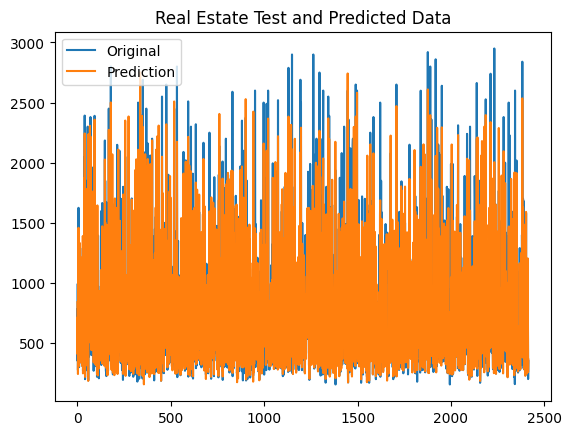

In [41]:
# Plot Actual VS Prediction

x_ax = range(len(y_apartments_rating_test))
plt.plot(x_ax, y_apartments_rating_test, label="Original")
plt.plot(x_ax, y_pred_xgb3, label="Prediction")
plt.title("Real Estate Test and Predicted Data")
plt.legend()
plt.show()

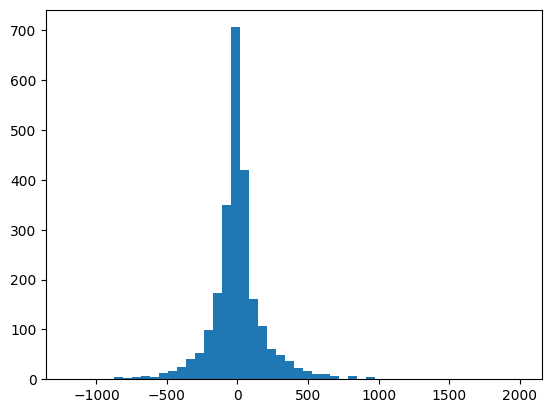

In [42]:
# Plot Error Distribution

dfff = pd.DataFrame()
dfff['original'] = y_apartments_rating_test

dfff['predicted'] = y_pred_xgb3
dfff['difference'] = dfff['original'] - dfff['predicted']
plt.hist(dfff['difference'], bins=50)
plt.show()

## Best Model Houses (without Rating Metrics)

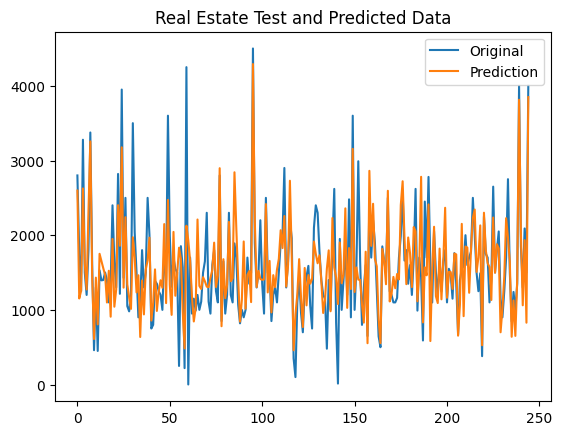

In [44]:
# Plot Actual VS Prediction

x_ax = range(len(y_houses_test))
plt.plot(x_ax, y_houses_test, label="Original")
plt.plot(x_ax, y_pred_xgb2, label="Prediction")
plt.title("Real Estate Test and Predicted Data")
plt.legend()
plt.show()

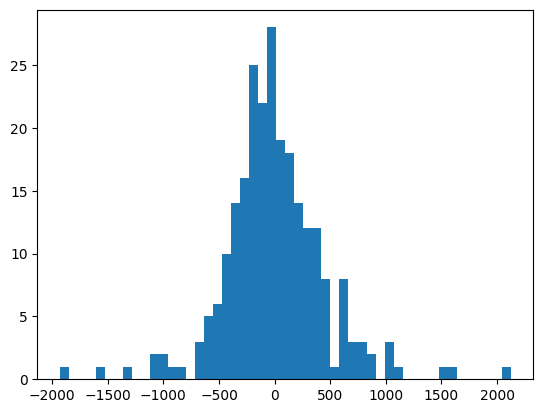

In [47]:
# Plot Error Distribution

dfff = pd.DataFrame()
dfff['original'] = y_houses_test

dfff['predicted'] = y_pred_xgb2
dfff['difference'] = dfff['original'] - dfff['predicted']
plt.hist(dfff['difference'], bins=50)
plt.show()

# Save & Store

In [48]:
# Best partments model trained on the dataset with rating metrics
filename = 'best_model_apartments.sav'
joblib.dump(xgb_model3, filename)

# Best houses model trained on the regular dataset
filename = 'best_model_houses.sav'
joblib.dump(xgb_model2, filename)

['best_model_houses.sav']

# Load & Test

In [ ]:
loaded_model = joblib.load('C:/Users/Aist/Desktop/AIST Projects/Best Model/best_model_apartments.sav')
result = loaded_model.score(X_apartments_test, y_apartments_test)
print(result)